# MRS Encircled Energy Fraction
In this notebook we determine the encircled energy fraction
  
The notebook was created on: May 9th 2018  
The author of the notebook is: Ioannis Argyriou (Institute of Astronomy, KUL)  
The author's email is: ioannis.argyriou@kuleuven.be

In [1]:
import funcs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from shapely.geometry import Point
import shapely.affinity
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# 1-Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# 3-load the MRS distortion maps, they are used extensively in a multitude of python functions relating to the analysis of MRS data
band     = '1A' # this is the spectral band (side of the slope image) to be analyzed
d2cMaps   = funcs.load_obj('d2cMaps_band'+band+'_tr80pc',path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates
det_dims = (1024,1032) # placeholder for the dimension of the detector

psffits,specres_table = funcs.get_cdps(band,cdpDir)[3:5]

In [3]:
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
print('There are {} spectral bins'.format(len(lambcens)))
funcs.save_obj(lambcens,'spec_grid_wavelengths_band{}'+band)

There are 598 spectral bins


In [4]:
# experiment
lambcens2,lambfwhms2 = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table,oversampling = 0.5)
print('There are {} spectral bins'.format(len(lambcens2)))

There are 299 spectral bins


<IPython.core.display.Javascript object>


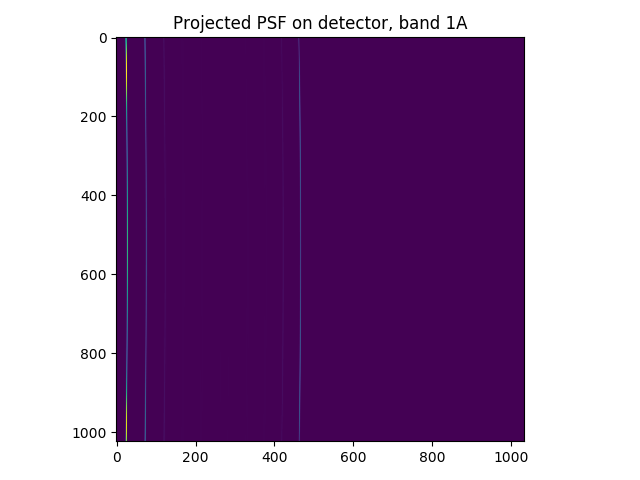

In [5]:
source_alpha_center = 0.
source_beta_center  = 0.

psf = funcs.evaluate_psf_cdp(psffits,d2cMaps,source_center=[source_alpha_center,source_beta_center])

plt.figure()
plt.imshow(psf)
plt.title('Projected PSF on detector, band {}'.format(band))
plt.tight_layout()

In [6]:
# Define radii to be inspected (in arcseconds)
radii = np.arange(funcs.mrs_aux(band)[5],funcs.mrs_aux(band)[7][0]/8.,0.01)

<IPython.core.display.Javascript object>


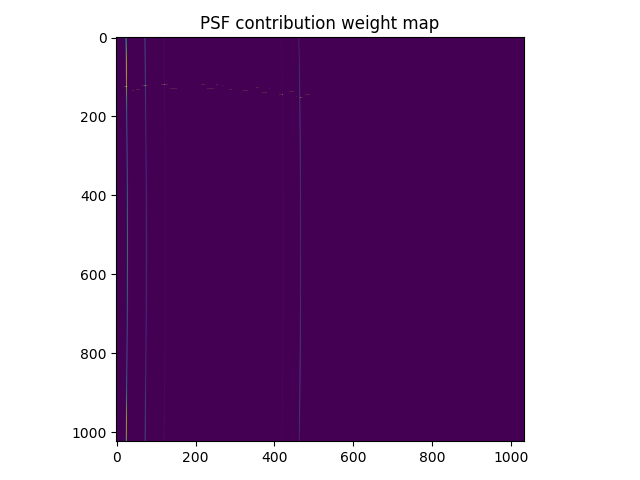

<IPython.core.display.Javascript object>


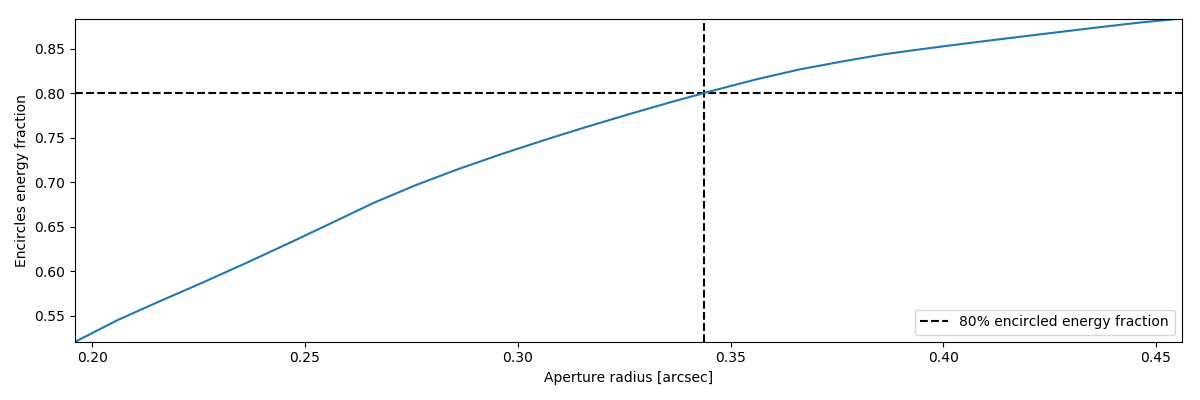

In [7]:
# perform example calculation in one spectral bin
ibin = 100

#--delineate spectral bin
i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
BinMask = np.zeros(det_dims); BinMask[i,j] = 1.
psf_BinMasked = psf*BinMask

#--define basic aperture parameters
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
aper_params = ((source_alpha_center, source_beta_center),(1,1),0)

encircled_energy_fraction = np.zeros(len(radii))
for k,radius in enumerate(radii):
    weight_map = np.zeros((1024,1032))

    # Let's create a circle of specified radius around specified aperture center:
    circ = shapely.geometry.Point(aper_params[0]).buffer(radius)

    # Let's create the ellipse along x and y:
    ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellrot
    aperture_area = aperture.area
    
    # define slicer-projected polygon/trapezoid (in IFU alpha-beta coordinates) for each pixel
    for ij in zip(i,j):
        xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
              [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
              [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
              [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
        polygon_shape = Polygon(xy)
        
        # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
        weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area
    
    # introduce factor for the contribution of each PSF portion to total signal
    psf_BinMasked_AperMasked = psf*weight_map
    
    # the encircled energy fraction is defined as the ratio of the PSF inside the aperture vs the total PSF in the MRS FoV
    encircled_energy_fraction[k] = psf_BinMasked_AperMasked.sum()/psf_BinMasked.sum()
    
plt.figure()
plt.title('PSF contribution weight map')
plt.imshow(weight_map)
plt.imshow(BinMask,alpha=0.3)
plt.imshow(psf,alpha=0.6)
plt.tight_layout()

plt.figure(figsize=(12,4))
irad = interp1d(encircled_energy_fraction,radii)(0.8)
plt.plot(radii,encircled_energy_fraction)
plt.vlines(irad,encircled_energy_fraction.min(),encircled_energy_fraction.max(),linestyle='dashed',label='80% encircled energy fraction')
plt.hlines(0.8,radii.min(),radii.max(),linestyle='dashed')
plt.xlim(radii.min(),radii.max())
plt.ylim(encircled_energy_fraction.min(),encircled_energy_fraction.max())
plt.legend(loc='lower right')
plt.xlabel('Aperture radius [arcsec]')
plt.ylabel('Encircles energy fraction')
plt.tight_layout()

In [49]:
# perform analysis in all spectral bins on detector (excluding the ones at the upper and lower edges)
omit_bins = len(lambcens)/10
encircled_energy_fractions = [[] for i in range(omit_bins,len(lambcens)-omit_bins)]
for m,ibin in enumerate(range(omit_bins,len(lambcens)-omit_bins)):
    if ibin%100 == 0: print( '{}/{} bins processed'.format(ibin,range(omit_bins,len(lambcens)-omit_bins)[-1] ))
    i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    BinMask = np.zeros(det_dims); BinMask[i,j] = 1.
    psf_BinMasked = psf*BinMask
    
    # specify aperture parameters
    aper_params = ((source_alpha_center, source_beta_center),(1,1),0)

    encircled_energy_fractions[m] = np.zeros(len(radii))
    for k,radius in enumerate(radii):
        weight_map = np.zeros((1024,1032))

        # create aperture
        circ = shapely.geometry.Point(aper_params[0]).buffer(radius)
        ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))
        ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

        # save final output as the aperture and calculate the aperture area
        aperture = ellrot
        aperture_area = aperture.area
    
        # define slicer-projected polygon/trapezoid (in IFU alpha-beta coordinates) for each pixel
        for ij in zip(i,j):
            xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
                  [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
                  [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
                  [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
            polygon_shape = Polygon(xy)

            # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
            weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area

        # introduce factor for the contribution of each PSF portion to total signal
        psf_BinMasked_AperMasked = psf*weight_map

        # the encircled energy fraction is defined as the ratio of the PSF inside the aperture vs the total PSF in the MRS FoV
        encircled_energy_fractions[m][k] = psf_BinMasked_AperMasked.sum()/psf_BinMasked.sum()
print('DONE')

100/481 bins processed
200/481 bins processed
300/481 bins processed
400/481 bins processed
500/481 bins processed
481/481 bins processed


In [53]:
# # uncomment to save output
# funcs.save_obj(encircled_energy_fractions,'encircled_energy_fractions_band'+band)

<IPython.core.display.Javascript object>


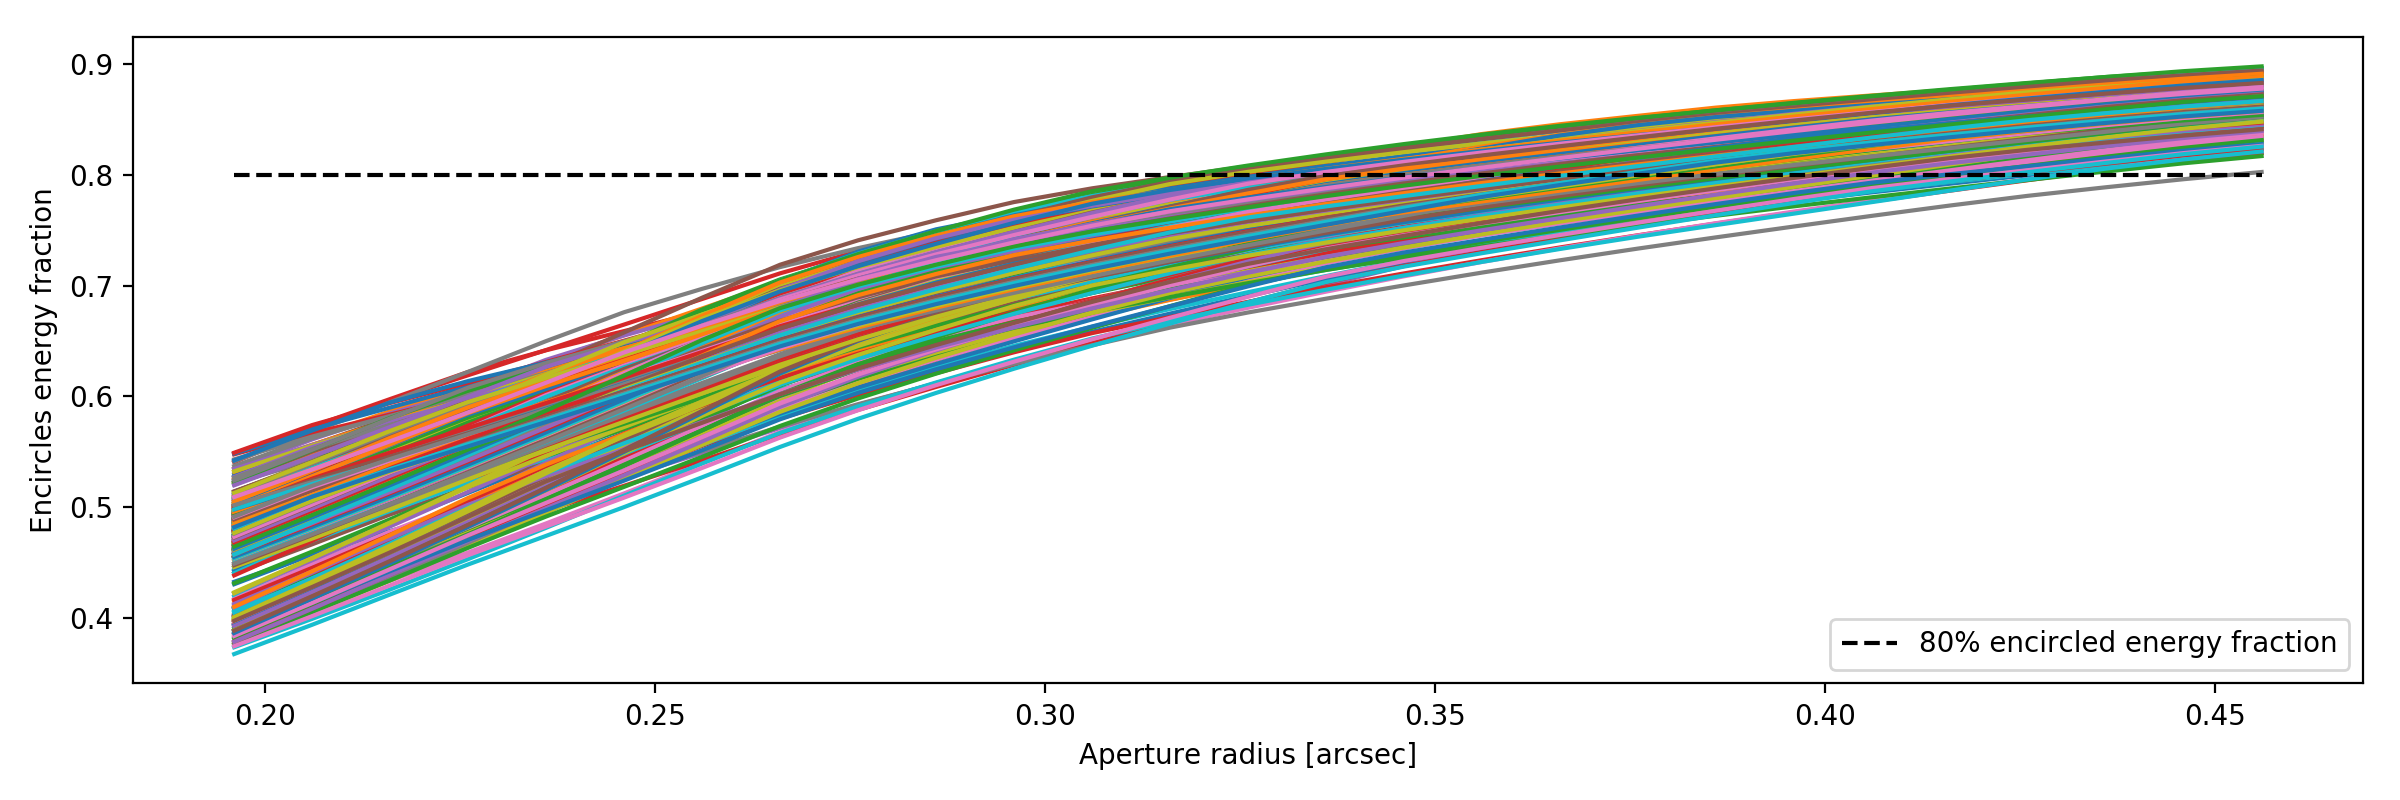

In [50]:
# plot all curves of growth
plt.figure(figsize=(12,4))
for ibin in range(30,len(encircled_energy_fractions)):
    plt.plot(radii,encircled_energy_fractions[ibin],zorder=0)
plt.hlines(0.8,radii.min(),radii.max(),linestyle='dashed',label='80% encircled energy fraction',zorder=1)
plt.legend(loc='lower right')
plt.xlabel('Aperture radius [arcsec]')
plt.ylabel('Encircles energy fraction')
plt.tight_layout()

<IPython.core.display.Javascript object>


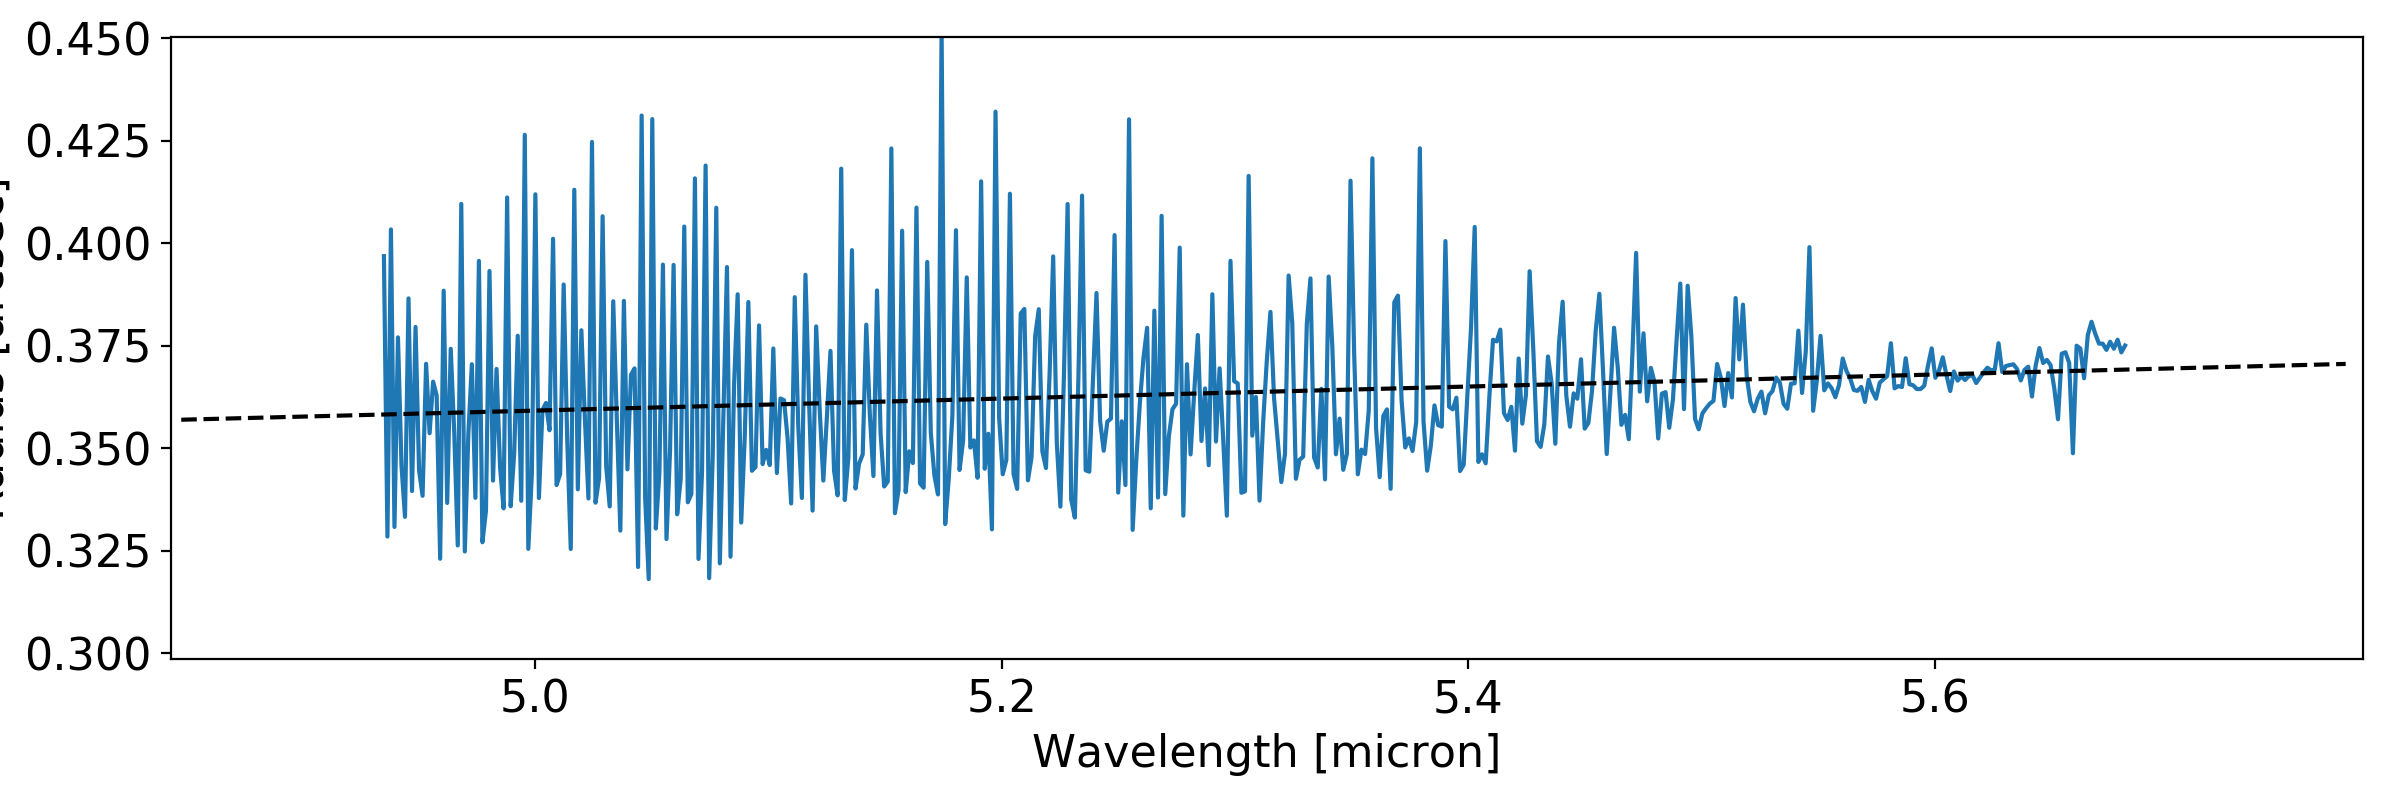

In [55]:
final_rad = np.zeros(len(encircled_energy_fractions))
for ibin in range(len(encircled_energy_fractions)):
    final_rad[ibin] = interp1d(encircled_energy_fractions[ibin],radii)(0.8)

plt.figure(figsize=(12,4))
plt.plot(lambcens[omit_bins:-omit_bins],final_rad)
popt = np.polyfit(lambcens[omit_bins:-omit_bins],final_rad,1)
poly = np.poly1d(popt)
plt.plot(lambcens,poly(lambcens),'k',linestyle='dashed')
plt.xlabel('Wavelength [micron]',fontsize=16)
plt.ylabel('Radius [arcsec]',fontsize=16)
plt.ylim(0)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

ifinal_rad = poly(lambcens)

In [54]:
# # uncomment to save output
# funcs.save_obj(ifinal_rad,'eighty_percent_encircled_energy_fraction_aperture_radius_band{}'.format(band))